In [1]:
import pandas as pd
import os
import tqdm
import sys
sys.path.append("..")
import aux.models as aux
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
def ensure_monotonic(row):
    t = row['sojourn_time']
    c = row['cdf']
    if (t != 0) & (c == 0):
        return 1
    return c

In [3]:
method1 = [f for f in os.listdir('sweep/method1')]

In [4]:
method1_data = {}
for f in tqdm.tqdm_notebook(method1):
    if f[-4:] == '.csv' and 'runtime' not in f:
        parts = f.split('=')
        rho = float(parts[4][:-4])
        R = int(parts[3][:-4])
        cdf = pd.read_csv('sweep/method1/' + f, index_col=0)
        cdf['cdf'] = cdf.apply(ensure_monotonic, axis=1)
        runtime = pd.read_csv('sweep/method1/' + f[:-4] + '-runtime.csv')['runtime'][0]
        method1_data[(R, rho)] = {'cdf': cdf, 'runtime': runtime}

In [5]:
method2 = [f for f in os.listdir('sweep/method2')]

In [6]:
method2_data = {}
for f in tqdm.tqdm_notebook(method2):
    if f[-4:] == '.csv' and 'runtime' not in f:
        parts = f.split('=')
        rho = float(parts[3][:-4])
        R = int(parts[2][:-4])
        cdf = pd.read_csv('sweep/method2/' + f, index_col=0)
        cdf['cdf'] = cdf.apply(ensure_monotonic, axis=1)
        runtime = pd.read_csv('sweep/method2/' + f[:-4] + '-runtime.csv')['runtime'][0]
        method2_data[(R, rho)] = {'cdf': cdf, 'runtime': runtime}

In [7]:
simulations = [f for f in os.listdir('sweep/simulation') if f != '.DS_Store']

In [8]:
simulation_data = {}
for f in tqdm.tqdm_notebook(simulations):
    parts = f.split('=')
    rho = float(parts[2])
    R = int(parts[1][:-4])
    runtimes = pd.read_csv('sweep/simulation/' + f + '/' + f + '-runtimes.csv', index_col=0)
    runtime = runtimes['run_time'].mean()
    recs = []
    for trial in range(40):
        recs.append(pd.read_csv('sweep/simulation/' + f + '/sim' + str(trial) + '.pq', index_col=0))
    cdf = pd.concat([recs[i].set_index('sojourn_time') for i in range(40)], axis=1).mean(axis=1)
    simulation_data[(R, rho)] = {'cdf': cdf, 'runtime': runtime}

In [9]:
Rs = []
rhos = []
runtime_m1 = []
runtime_m2 = []
runtime_sim = []
m1_errors = []
m2_errors = []

possible_rhos = [r / 100 for r in range(1, 100)]
for R in tqdm.tqdm_notebook(range(1, 11)):
    for rho in possible_rhos:
        Rs.append(R)
        rhos.append(rho)
        runtime_m1.append(method1_data[(R, rho)]['runtime'])
        runtime_sim.append(simulation_data[(R, rho)]['runtime'])
        try:
            runtime_m2.append(method2_data[(R, rho)]['runtime'])
        except:
            runtime_m2.append(np.nan)
        m1_errors.append(aux.wasserstein_distance(method1_data[(R, rho)]['cdf']['cdf'], simulation_data[(R, rho)]['cdf'], 0.01))
        try:
            m2_errors.append(aux.wasserstein_distance(method2_data[(R, rho)]['cdf']['cdf'], simulation_data[(R, rho)]['cdf'], 0.01))
        except:
            m2_errors.append(np.nan)

In [10]:
data = pd.DataFrame({
    'R': Rs,
    'rho': rhos,
    'runtime m1': runtime_m1,
    'runtime m2': runtime_m2,
    'runtime simulation': runtime_sim,
    'error m1': m1_errors,
    'error m2': m2_errors
})
data

R   rho  runtime m1   runtime m2  runtime simulation  error m1  error m2
0     1  0.01   66.095318  6127.519990            0.015387  0.072477  0.035876
1     1  0.02  144.038235  6269.634184            0.020566  0.027819  0.101871
2     1  0.03   84.914537  6445.225877            0.026465  0.013382  0.084353
3     1  0.04   94.926623  6652.940699            0.033292  0.015169  0.101264
4     1  0.05  167.777118  6906.625530            0.037854  0.012560  0.096038
..   ..   ...         ...          ...                 ...       ...       ...
985  10  0.95   15.698070  6754.534690            0.703848  0.043019  0.097240
986  10  0.96   15.678124  6787.355867            0.725698  0.039402  0.094334
987  10  0.97   15.597895  6742.047845            0.729212  0.041340  0.097131
988  10  0.98   15.663351  6817.269502            0.732983  0.039168  0.095323
989  10  0.99   15.717708  6842.064232            0.729431  0.041981  0.099106

[990 rows x 7 columns]

# Comparing Method 1, Method 2, and Simulation:

In [11]:
def plot_runtime_and_errors(R):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['error m1'], linestyle='solid', c='black')
    ax[0].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['error m2'], linestyle='dotted', c='black')
    ax[0].set_xlabel('Traffic Intensity, ρ', fontsize=20)
    ax[0].set_ylabel('Wasserstein Distance', fontsize=20)
    ax[1].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['runtime m1'], label='Method 1', linestyle='solid', c='black')
    ax[1].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['runtime m2'], label='Method 2', linestyle='dotted', c='black')
    ax[1].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['runtime simulation'], label='Simultion', linestyle='dashed', c='black')
    ax[1].set_xlabel('Traffic Intensity, ρ', fontsize=20)
    ax[1].set_ylabel('Runtime (s)', fontsize=20)
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.28, 0.85), fontsize=18, ncol=3)
    fig.suptitle(f'R = {R}', fontsize=28, y=1.15)
    plt.tight_layout()
    return fig

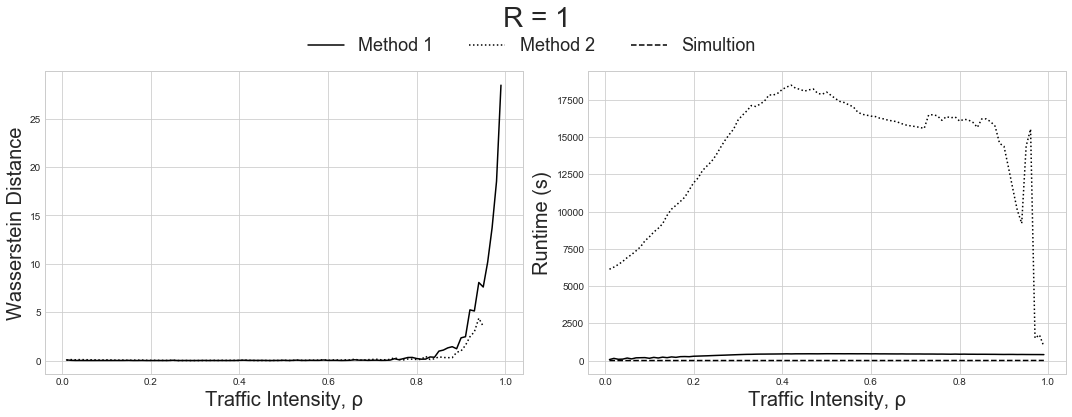

In [12]:
plot_runtime_and_errors(R=1);

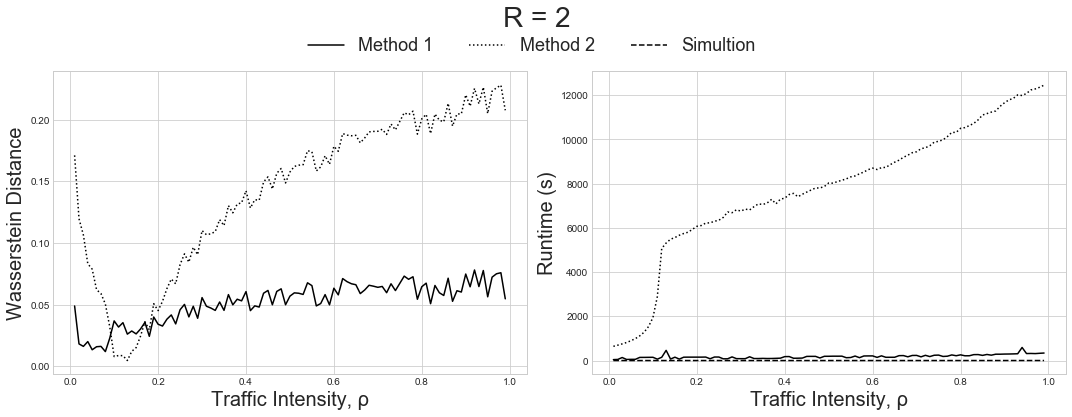

In [13]:
plot_runtime_and_errors(R=2);

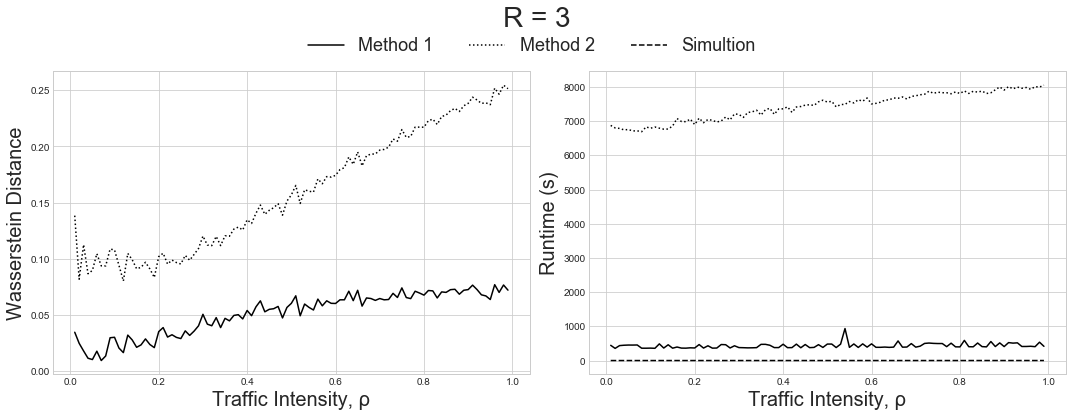

In [14]:
plot_runtime_and_errors(R=3);

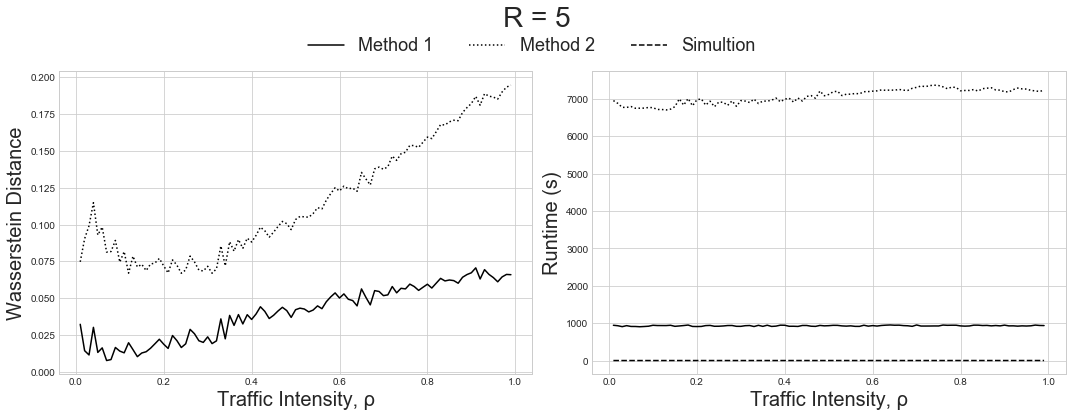

In [15]:
plot_runtime_and_errors(R=5);

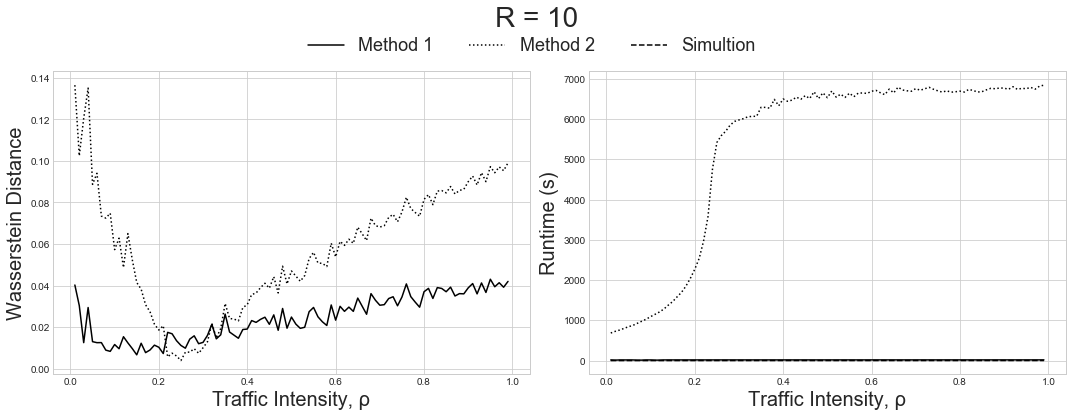

In [16]:
plot_runtime_and_errors(R=10);

+ Note here that runtimes for the simulation are the average runtime per trial.
+ We could sum up the trial runtimes, but that would be highly dependent on the chosen number of trials.
+ Having said that, even for one trial the runtime is highly dependent on the max_simtulation_time.
+ Should we even be reporting simulation runtimes?

# Just looking at Methods 1 and 2 in isolation:

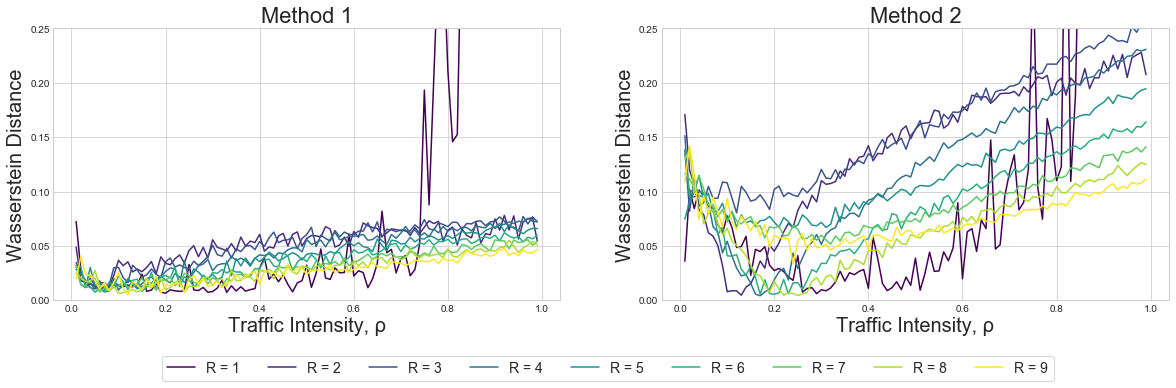

In [17]:
fig, axarr = plt.subplots(1, 2, figsize=(20, 5))
vals = np.linspace(0, 1, 9)
for R, v in zip(range(1, 10), vals):
    col = plt.cm.viridis(v)
    axarr[0].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['error m1'], c=col, label=f'R = {R}')
axarr[0].set_ylim(0, 0.25)
axarr[0].set_xlabel('Traffic Intensity, ρ', fontsize=20)
axarr[0].set_ylabel('Wasserstein Distance', fontsize=20)
axarr[0].set_title("Method 1", fontsize=22)

for R, v in zip(range(1, 10), vals):
    col = plt.cm.viridis(v)
    axarr[1].plot(data[data['R'] == R]['rho'], data[data['R'] == R]['error m2'], c=col)
axarr[1].set_ylim(0, 0.25)
axarr[1].set_xlabel('Traffic Intensity, ρ', fontsize=20)
axarr[1].set_ylabel('Wasserstein Distance', fontsize=20)
axarr[1].set_title("Method 2", fontsize=22)

axarr[0].legend(fontsize=14, loc='center left', bbox_to_anchor=(0.2, -0.25), ncol=9, frameon=True)

plt.show()